# Generalized Linear Models

A [Generalized Linear Model](https://en.wikipedia.org/wiki/Generalized_linear_model) (GLM), not to be confused with a [General Linear Model](https://en.wikipedia.org/wiki/General_linear_model), is a regression model that trains a filter to model single neuron activity as it relates to some other variable. For example, to predict the spike counts produced by a single neuron (Y) in response to licking events (X). The GLM model can be represented by the following equation:
$y(t) = Poiss(f(k * X_{t}))$, where `Poiss` is a poisson process and `f` is a non-linearity function, in this case $f(x) = e^x$

To train a GLM, we start by creating a *design matrix* from the visual stimulus. The design matrix is the input, X_train, provided to the GLM for training along with known spike counts in each trial, Y_train. The GLM uses [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) to train the filter vector that maximizes the likelihood of producing a given spike train from the inputted design matrix. To predict the spike activity of a neuron, the filter is first convolved with the stimulus vector. Next, the GLM employs a non-linearity step (exponential in this case), followed by poisson generation to generate specific spike counts as shown in the figure below.

This notebook demonstrates the usage of a Poisson GLM to model and reproduce the spiking activity of single neurons in response to a visual stimulus. GLMs are trained using synthetic data, as well as real data from the Allen Institute **Visual Coding - Neuropixels** dataset.

For more information on applying GLMs for predicting spiking activity, see the Pillow Lab's [GLM Slides](https://github.com/pillowlab/GLMspiketraintutorial/tree/master/slides) and Neuromatch Academy's [GLM tutorial](https://compneuro.neuromatch.io/tutorials/W1D3_GeneralizedLinearModels/student/W1D3_Tutorial1.html).

![glm.png](../../data/images/glm.png)

Modified from Slide 6, *[Generalized linear models for cracking the neural code](https://pillowlab.princeton.edu/pubs/pillow_TutorialSlides_Cosyne2018.pdf)*, Pillow Lab

### Environment Setup

In [1]:
try:
    from databook_utils.dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [2]:
import os
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

from math import ceil
from scipy import interpolate
from functools import reduce

from scipy.optimize import minimize
from sklearn.metrics import r2_score

%matplotlib inline

### Downloading File

In [3]:
dandiset_id = "000021"
dandi_filepath = "sub-726298249/sub-726298249_ses-754829445.nwb"
download_loc = "."

In [4]:
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc)
nwb = io.read()

A newer version (0.62.2) of dandi/dandi-cli is available. You are using 0.61.2


File already exists
Opening file


c:\Users\carter.peene\Desktop\Projects\openscope_databook\databook_env\lib\site-packages\hdmf\utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
c:\Users\carter.peene\Desktop\Projects\openscope_databook\databook_env\lib\site-packages\hdmf\utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)


### The GLM
The functions below are used in training the GLM. 


The function `fit_lnp` takes in the *design_matrix* ~as~, `X`, produced from the stimulus and the observed spike counts, `y`. It also takes the length of the filter to train, `d`, and the regularization coefficient, `lam`,. First, the function initializes a random filter of length `d` and then uses the `neg_log_like_lnp` function to perform Maximum Likelihood Estimation to train the filter. 

`neg_log_lik_lnp` computes the negative log likelihood for a vector of filter weights `theta`, the design matrix `X`, and the observed spike counts, `y`. The `Cinv` matrix, a diagonal matrix with the regularization coefficient, is applied for regularization. It would also help to explain each function by its inputs and outputs.

The `predict` function perform the inverse operation, applying a trained filter `weights` to the *design matrix* `X`, and adding a constant, yielding the spike probability over time. 

`predict_spikes` takes the spike rate prediction and runs it through Poisson generation, adding noise and producing a set of predicted spike counts. Because the poisson generation is non-deterministic, it will produce different results every time.

This code was adapted from [this code](https://github.com/pillowlab/GLMspiketraintutorial/tree/master) from the Pillow Lab, with the regularization code from [this tutorial](https://compneuro.neuromatch.io/tutorials/W1D3_GeneralizedLinearModels/student/W1D3_Tutorial1.html) from Neuromatch Academy.

In [5]:
def neg_log_lik_lnp(theta, X, y, Cinv):
  # Compute the Poisson log likelihood
  rate = np.exp(X @ theta)
  log_lik = y @ np.log(rate) - rate.sum()
  log_lik -= theta.T @ Cinv @ theta

  return -log_lik

In [6]:
def fit_lnp(X, y, lam=0):
  filt_len = X.shape[1]
  Imat = np.identity(filt_len) # identity matrix of size of filter + const
  Imat[0,0] = 0
  Cinv = lam*Imat

  # Use a random vector of weights to start (mean 0, sd .2)
  x0 = np.random.normal(0, .2, filt_len)
  print("y:",y.shape,"X:",X.shape,"x0:",x0.shape)

  # Find parameters that minimize the negative log likelihood function
  res = minimize(neg_log_lik_lnp, x0, args=(X, y, Cinv))

  return res["x"]

In [7]:
def predict(X, weights, constant):
    y = np.exp(X @ weights + constant)
    return y

def predict_spikes(X, weights, constant):
    rate = predict(X, weights, constant)
    spks = np.random.poisson(np.matrix.transpose(rate))
    return spks

### Synthetic Data
The cells below prepare the synthetic data (stimulus and spiking data), and show how to train a GLM. 

`make_flashes` produces boxcar stimulus that imitate binary flashes. 

`make_spikes` utilizes the same mathematics as the GLM's prediction and generates spikes that have a direct relationship with the brightness of the synthetic stimulus. It simply multiplies the stimulus by a given coefficient `coeff`, and adds a given constant, `baseline_rate`. It runs the resulting rate through exponentiation and then generates Poission distributed spike counts with this as the spiking probability.

0.0 300.0
30000


Text(0, 0.5, "'Brightness'")

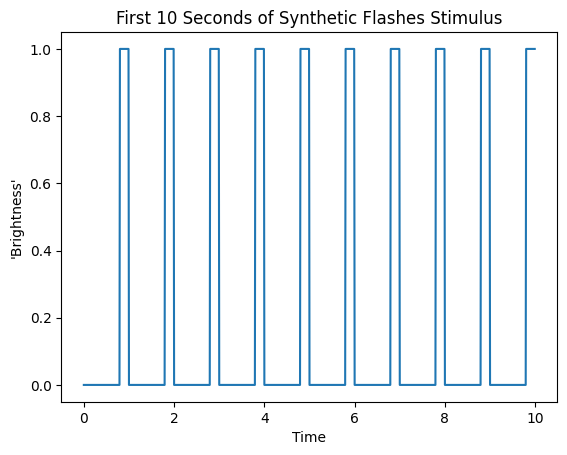

In [8]:
def make_flashes(time_start, time_end, pattern, n_repeats):
    flashes = np.tile(pattern, n_repeats)
    time_axis = np.linspace(time_start, time_end, len(flashes))
    return time_axis, flashes

syn_time_axis, syn_flashes = make_flashes(0, 300, [0]*80 + [1]*20, 300)
print(syn_time_axis[0], syn_time_axis[-1])
print(len(syn_flashes))

plt.plot(syn_time_axis[:1000], syn_flashes[:1000])
plt.title("First 10 Seconds of Synthetic Flashes Stimulus")
plt.xlabel("Time")
plt.ylabel("'Brightness'")

0.1353352832366127 0.0820849986238988
30000


Text(0, 0.5, '# Spikes')

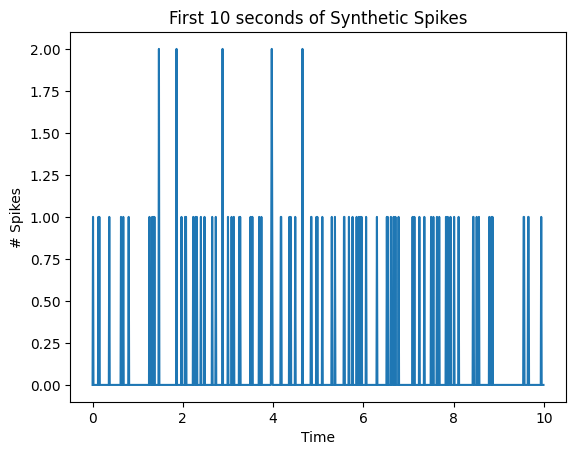

In [9]:
def make_spikes(stim, baseline_rate, coeff, return_exp=False):
    weighted_stim = (stim*coeff) + baseline_rate
    exp_stim = np.exp(weighted_stim)
    print(np.max(exp_stim), np.min(exp_stim))
    spikes = np.random.poisson(exp_stim)
    if return_exp:
        return spikes, weighted_stim, exp_stim
    return spikes

# set with parameters -2.5 and 0.5, the GLM should learn these parameters
syn_spikes, syn_weight, syn_exp = make_spikes(syn_flashes, -2.5, 0.5, return_exp=True)
print(len(syn_spikes))

plt.plot(syn_time_axis[:1000], syn_spikes[:1000])
plt.title("First 10 seconds of Synthetic Spikes")
plt.xlabel("Time")
plt.ylabel("# Spikes")

### Design Matrix
The GLM takes in the following *design matrix* to conduct Maximum Likelihood Estimation. The design matrix must have dimensions `time` * `d`, where time is the length of the stimulus, and d is the length of the filter to be trained. It can be seen below that it is simply slices of the `d` most recent stimulus values for each timepoint in the stimulus. Importantly, a GLM also yields a `constant` value with each filter. This constant term is the bias term that captures the spike count variance unexplained by the input variables. For this, we simply add a 1 to each row in the design matrix. The resulting column of 1s produces the bias term from the MLE.

The function `build_design_matrix` returns such a design_matrix from a given `stim` array and a filter length `d`. It can be seen below that the bins of the second dimension of the design matrix represent the stimulus values preceding the stimulus event, so the time axis is time prior the 'current time'. The column of ones to product the GLM constant does not have a temporal relationship to the latest stimulus time, so its x value in the matrix undefined. 

In [10]:
def build_design_mat(stim, d, include_const=True):
  # Create version of stimulus vector with zeros before onset
  padded_stim = np.concatenate([np.zeros(d-1), stim])

  # Construct a matrix where each row has the d frames of
  # the stimulus preceding and including timepoint t
  T = len(stim)  # Total number of timepoints (hint: number of stimulus frames)
  X = np.zeros((T, d))
  for t in range(T):
      X[t] = padded_stim[t:t + d]

  if include_const:
    constant = np.ones_like(stim)
    return np.column_stack([constant, X])
  return X

(30000, 26)


Text(0.5, 1.0, 'Synthetic Stimulus Design Matrix with Constant Column')

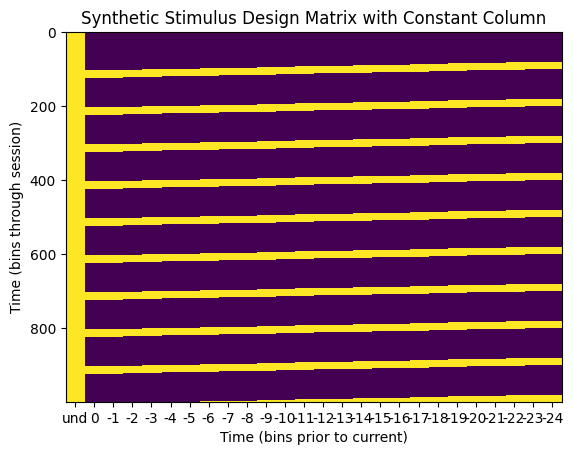

In [11]:
syn_design_mat = build_design_mat(syn_flashes, 25)
print(syn_design_mat.shape)
plt.imshow(syn_design_mat[:1000], aspect="auto", interpolation="none")
plt.xlabel("Time (bins prior to current)")
xaxis_step = 1
xpositions = range(0,syn_design_mat.shape[1])[::xaxis_step]
time_offset_axis = range(0,-syn_design_mat.shape[1]+1,-1)
xticks = (["und"] + list(time_offset_axis))[::xaxis_step]
plt.xticks(xpositions, xticks)
plt.ylabel("Time (bins through session)")
plt.title("Synthetic Stimulus Design Matrix with Constant Column")

### Running on Synthetic Data
Below is an example of a trained GLM filter trained using a filter length of 25 and a regularization coefficient of $2^{10}$. During prediction, this filter would be convolved with the design matrix before undergoing the expontential non-linearity step to produce spike rate.

y: (30000,) X: (30000, 26) x0: (26,)
-2.4325110136550547


Text(0, 0.5, 'Unitless')

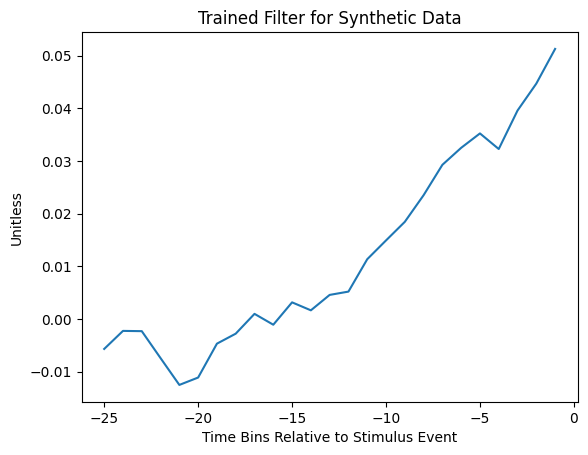

In [12]:
res = fit_lnp(syn_design_mat, syn_spikes, lam=2**10)
constant, filter = res[0], res[1:]
print(constant)
plt.plot(range(-len(filter),0), filter)
plt.title("Trained Filter for Synthetic Data")
plt.xlabel("Time Bins Relative to Stimulus Event")
plt.ylabel("Unitless")

### Testing Model

To get a sense of how the GLM performs on synthetic data, the function `test_synthetic_glm` is used to yield a constant and a filter of length 1. Since the synthetic spikes were produced with a constant `baseline_rate` and a coefficient `coeff`, we should expect the GLM to effectively reproduce these values in the constant and length 1 filter. The GLM performance is tested by iterating over successive values of regularization coefficient `lam` and the number of repeats of stimulus flashes, `n_repeats`, both ranging between 1 and $2^9$. The optimal values for these variables are obtained by maximixing the [Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) $R^2$. The results below indicate that as the regularization coefficient increases, the GLM performance starts to suffer. This is because higher regularization values promote a stronger tendency for trained filter values to stay closer to 0, limiting the MLE's ability to fit a model effectively. They also indicate that the GLM performance converges toward the real constant and coefficient values as the number of repeats of the stimulus increases because there is more data to train with.

In [13]:
def test_synthetic_glm(constant_in, coeff_in, flashes, constants, filters, r2s, lam=0, filt_len=1):
    design_mat = build_design_mat(flashes, d=filt_len)
    syn_spikes, syn_weights, syn_prob = make_spikes(flashes, constant_in, coeff_in, return_exp=True)

    res = fit_lnp(design_mat, syn_spikes, lam=lam)
    const, filt = res[0], res[1:]

    prob_predicted = predict(design_mat[:,1:], filt, const)
    spikes_predicted = predict_spikes(design_mat[:,1:], filt, const)
    r2 = r2_score(syn_spikes, prob_predicted)

    constants.append(const)
    filters.append(filt)
    r2s.append(r2)

In [14]:
repeats_vals = []
r_coeffs = []
r_constants = []
r_r2s = []

for i in range(10):
    n_repeats = 2**i
    time_axis, syn_flashes = make_flashes(0, n_repeats, [0]*80 + [1]*20, n_repeats)

    for j in range(10):
        test_synthetic_glm(-2.3, 2.3, syn_flashes, r_constants, r_coeffs, r_r2s)
        repeats_vals.append(n_repeats)

lambda_vals = []
l_coeffs = []
l_constants = []
l_r2s = []

time_axis, syn_flashes = make_flashes(0, 2**8, [0]*80 + [1]*20, 2**8)
design_mat = build_design_mat(syn_flashes, d=2)
for i in range(10):
    lam = 2**i

    for j in range(10):
        test_synthetic_glm(-2.3, 2.3, syn_flashes, l_constants, l_coeffs, l_r2s, lam=lam)
        lambda_vals.append(lam)

1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (200,) X: (200, 2) x0: (2,)
1.0 0.10025884372280375
y: (200,) X: (200, 2) x0: (2,)
1.0 0.10025884372280375
y: (200,) X: (200, 2) x0: (2,)
1.0 0.10025884372280375
y: (200,) X: (200, 2) x0: (2,)
1.0 0.10025884372280375
y: (200,) X: (200, 2) x0: (2,)
1.0 0.10025884372280375
y: (200,) X: (200, 2) x0: (2,)
1.0 0.10025884372280375
y: (200,) X: (200, 2) x0: (2,)
1.0 0.10025884372280375
y: (200,) X: (200, 2) x0: (2,)
1.0 0.1002

Text(0, 0.5, '$R^2$')

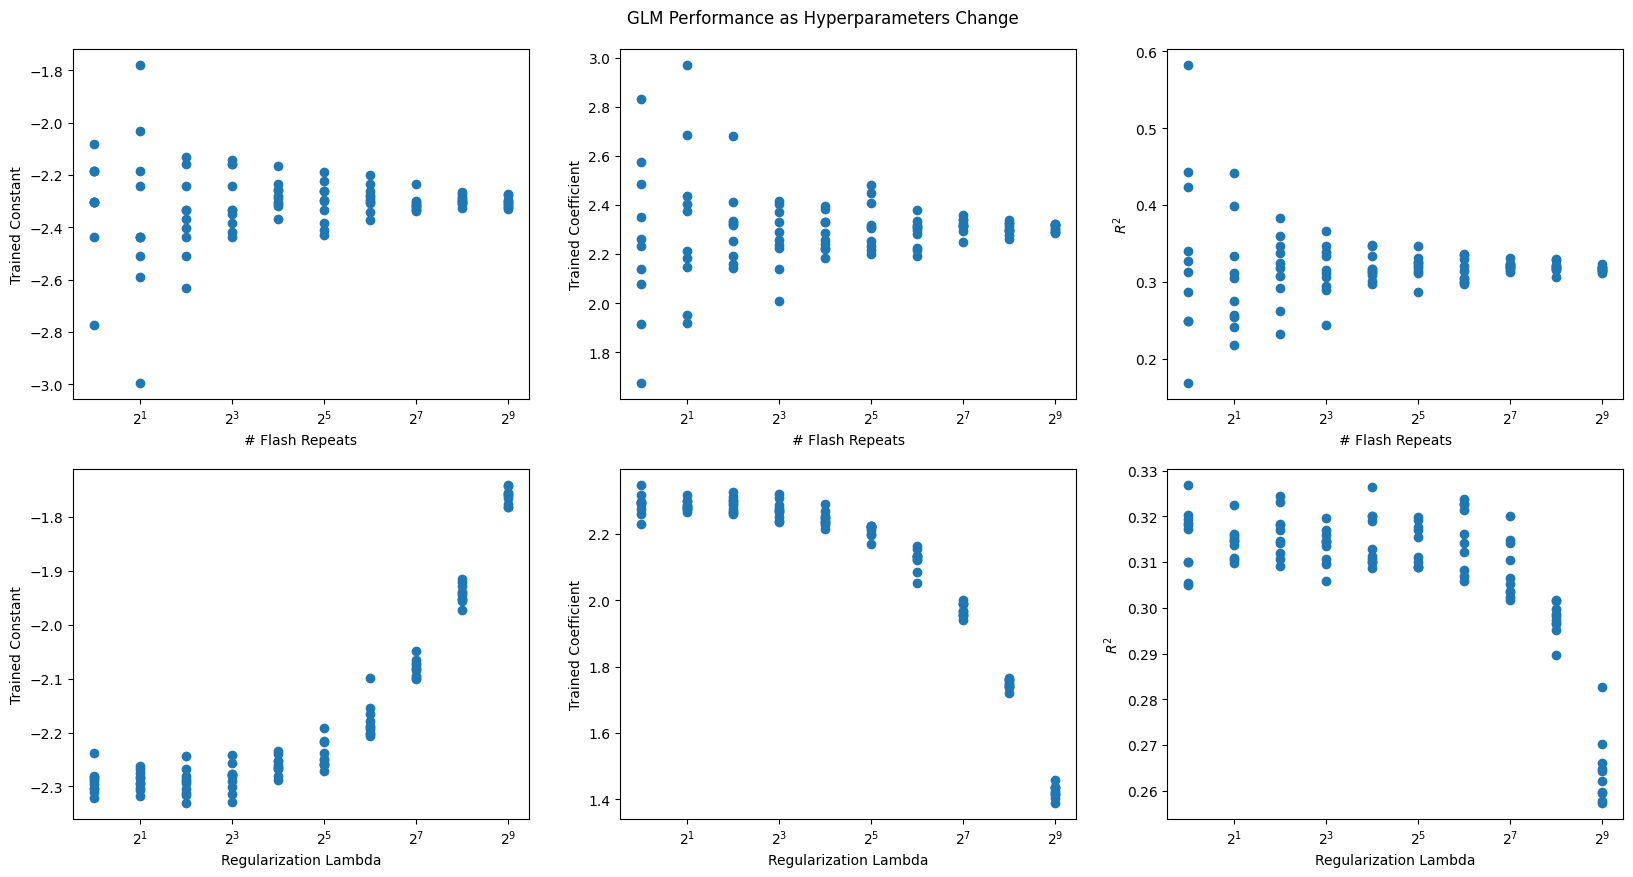

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))
fig.suptitle("GLM Performance as Hyperparameters Change", y=0.92)
for ax in axes.flatten()[:6]:
    ax.set_xscale("log", base=2)

axes[0][0].scatter(repeats_vals, r_constants)
axes[0][0].set_xlabel("# Flash Repeats")
axes[0][0].set_ylabel("Trained Constant")

axes[0][1].scatter(repeats_vals, r_coeffs)
axes[0][1].set_xlabel("# Flash Repeats")
axes[0][1].set_ylabel("Trained Coefficient")

axes[0][2].scatter(repeats_vals, r_r2s)
axes[0][2].set_xlabel("# Flash Repeats")
axes[0][2].set_ylabel("$R^2$")

axes[1][0].scatter(lambda_vals, l_constants)
axes[1][0].set_xlabel("Regularization Lambda")
axes[1][0].set_ylabel("Trained Constant")

axes[1][1].scatter(lambda_vals, l_coeffs)
axes[1][1].set_xlabel("Regularization Lambda")
axes[1][1].set_ylabel("Trained Coefficient")

axes[1][2].scatter(lambda_vals, l_r2s)
axes[1][2].set_xlabel("Regularization Lambda")
axes[1][2].set_ylabel("$R^2$")

## Real Data - Allen Institute Visual Coding dataset

### Extracting Spike Data
After examining the GLM on synthetic data to empirically evaluate hyperparameters, we test GLM performance on real data. First, desirable units are selected from the NWB File. Here, neurons are chosen from the primary visual cortex `VISp`. For convenience, the list of regions in this NWB file are displayed below. `brain_regions` can be altered to suit your preferences. Only units of "good" quality and a firing rate greater than 2 are selected. More information on unit quality metrics can be found in [Visualizing Unit Quality Metrics ](../visualization/visualize_unit_metrics.ipynb)

In [16]:
units = nwb.units

In [17]:
### use the electrodes table to devise a function which maps units to their brain regions

# select electrodes
channel_probes = {}

electrodes = nwb.electrodes
for i in range(len(electrodes)):
    channel_id = electrodes["id"][i]
    location = electrodes["location"][i]
    channel_probes[channel_id] = location

# function aligns location information from electrodes table with channel id from the units table
def get_unit_location(row):
    return channel_probes[int(row.peak_channel_id)]

all_regions = set(get_unit_location(row) for row in units)
print(all_regions)

{'', 'CA1', 'Eth', 'CA2', 'TH', 'APN', 'VISpm', 'VPM', 'LGd', 'DG', 'CA3', 'LP', 'PO', 'POL', 'VISam', 'VISp', 'PoT', 'VISrl'}


In [18]:
### selecting units spike times

brain_regions = ["VISp"]

# select units based if they have 'good' quality and exists in one of the specified brain_regions
units_spike_times = []
for location in brain_regions:
    location_units_spike_times = []
    for row in units:
        if get_unit_location(row) == location and row.quality.item() == "good" and row.firing_rate.item() > 2.0:
            location_units_spike_times.append(row.spike_times.item())
    units_spike_times += location_units_spike_times

print(len(units_spike_times))

124


### Extracting Real Flashes Data

Next, we retrieve the stimulus information (full-field flashes) from the dataset.
To ensure they have a regular timescale, they are interpolated. Set `bin_sz` to be the bin size used for the interpolation below. Since `bin_sz` affects the temporal resolution of spikes and stimulus, `bin_sz` might have a large impact on the runtime and the performance of the model. This is because given a filer length in seconds, the bin size determines how many weights the filter consists of. More weights might may improve the performance of the GLM but will increase the runtime.

The stimulus information are stored in a series of tables, one of which is the flashes presentations table. In this table, the black and white flash intervals are listed with their respective start times and stop times, where -1.0 (black) and 1.0 (white) encode the color. Between these intervals, the screen was grey. The code below extracts these flash intervals and generates the interpolated flashes array.

There are several types of stimulus from this experimental session, but for the purposes of this analysis only the (approx.) 300 seconds of flashes stimulus are used.

In [19]:
bin_sz = 0.050 # important for performance of GLM, be careful! 

In [20]:
flashes_table = nwb.intervals["flashes_presentations"]
flashes_table[:10]

start_time    stop_time stimulus_name  stimulus_block color  mask  \
id                                                                      
0   1285.60087  1285.851080       flashes             1.0  -1.0  None   
1   1287.60256  1287.852768       flashes             1.0  -1.0  None   
2   1289.60423  1289.854435       flashes             1.0  -1.0  None   
3   1291.60589  1291.856100       flashes             1.0  -1.0  None   
4   1293.60761  1293.857808       flashes             1.0   1.0  None   
5   1295.60925  1295.859455       flashes             1.0  -1.0  None   
6   1297.61096  1297.861155       flashes             1.0   1.0  None   
7   1299.61265  1299.862843       flashes             1.0   1.0  None   
8   1301.61429  1301.864488       flashes             1.0   1.0  None   
9   1303.61592  1303.866128       flashes             1.0  -1.0  None   

    opacity       phase            size units  stimulus_index  orientation  \
id                                                                           
0       1.0  [0.0, 0.0]  [300.0, 300.0]   deg             1.0          0.0   
1       1.0  [0.0, 0.0]  [300.0, 300.0]   deg             1.0          0.0   
2       1.0  [0.0, 0.0]  [300.0, 300.0]   deg             1.0          0.0   
3       1.0  [0.0, 0.0]  [300.0, 300.0]   deg             1.0          0.0   
4       1.0  [0.0, 0.0]  [300.0, 300.0]   deg             1.0          0.0   
5       1.0  [0.0, 0.0]  [300.0, 300.0]   deg             1.0          0.0   
6       1.0  [0.0, 0.0]  [300.0, 300.0]   deg             1.0          0.0   
7       1.0  [0.0, 0.0]  [300.0, 300.0]   deg             1.0          0.0   
8       1.0  [0.0, 0.0]  [300.0, 300.0]   deg             1.0          0.0   
9       1.0  [0.0, 0.0]  [300.0, 300.0]   deg             1.0          0.0   

   spatial_frequency  contrast                      tags  \
id                                                         
0         [0.0, 0.0]       0.8  [stimulus_time_interval]   
1         [0.0, 0.0]       0.8  [stimulus_time_interval]   
2         [0.0, 0.0]       0.8  [stimulus_time_interval]   
3         [0.0, 0.0]       0.8  [stimulus_time_interval]   
4         [0.0, 0.0]       0.8  [stimulus_time_interval]   
5         [0.0, 0.0]       0.8  [stimulus_time_interval]   
6         [0.0, 0.0]       0.8  [stimulus_time_interval]   
7         [0.0, 0.0]       0.8  [stimulus_time_interval]   
8         [0.0, 0.0]       0.8  [stimulus_time_interval]   
9         [0.0, 0.0]       0.8  [stimulus_time_interval]   

                                           timeseries  
id                                                     
0   [(3647, 1, timestamps pynwb.base.TimeSeries at...  
1   [(3648, 1, timestamps pynwb.base.TimeSeries at...  
2   [(3649, 1, timestamps pynwb.base.TimeSeries at...  
3   [(3650, 1, timestamps pynwb.base.TimeSeries at...  
4   [(3651, 1, timestamps pynwb.base.TimeSeries at...  
5   [(3652, 1, timestamps pynwb.base.TimeSeries at...  
6   [(3653, 1, timestamps pynwb.base.TimeSeries at...  
7   [(3654, 1, timestamps pynwb.base.TimeSeries at...  
8   [(3655, 1, timestamps pynwb.base.TimeSeries at...  
9   [(3656, 1, timestamps pynwb.base.TimeSeries at...

start: 1285.6008699215513 end: 1584.1002475386938
5969


Text(0, 0.5, 'Presence of Flash')

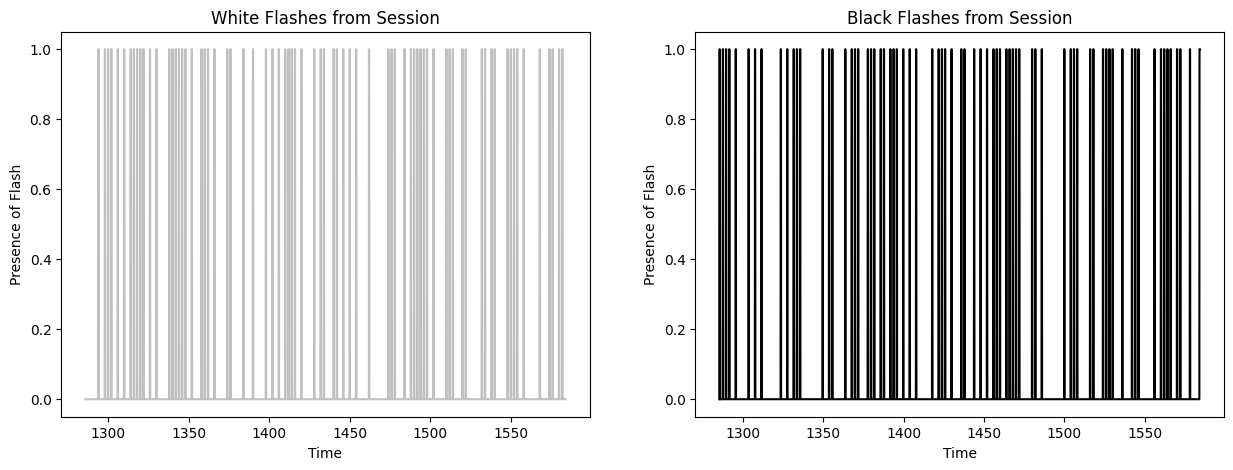

In [21]:
start_time = np.min(flashes_table.start_time)
end_time = np.max(flashes_table.stop_time)
time_axis = np.linspace(start_time, end_time, num=int((end_time-start_time)//bin_sz), endpoint=False)

print("start:",start_time,"end:",end_time)
print(len(time_axis))

white_flashes = np.zeros(len(time_axis))
black_flashes = np.zeros(len(time_axis))
table_idx = 0
for i, ts in enumerate(time_axis):
    if ts > flashes_table.start_time[table_idx] and ts < flashes_table.stop_time[table_idx]:
        if float(flashes_table.color[table_idx]) == 1.0:
            white_flashes[i] = 1.0
        if float(flashes_table.color[table_idx]) == -1.0:
            black_flashes[i] = 1.0
    elif ts < flashes_table.start_time[table_idx]:
        continue
    while ts > flashes_table.stop_time[table_idx]:
        table_idx += 1

fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(time_axis, white_flashes, color="silver")
axes[0].set_title("White Flashes from Session")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Presence of Flash")

axes[1].plot(time_axis, black_flashes, color="black")
axes[1].set_title("Black Flashes from Session")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Presence of Flash")

### Generating Filters
As with the synthetic data above, the design matrix is generated from the stimulus flashes. The filter length is set to 250 ms. Then, we train a GLM filter for each unit.  

(5969, 6)
(5969, 5)
(5969, 11)
range(0, 11)
['und', 0, -1, -2, -3, -4, 0, -1, -2, -3, -4]


Text(0.5, 1.0, 'Stimulus Design Matrix with Constant Column')

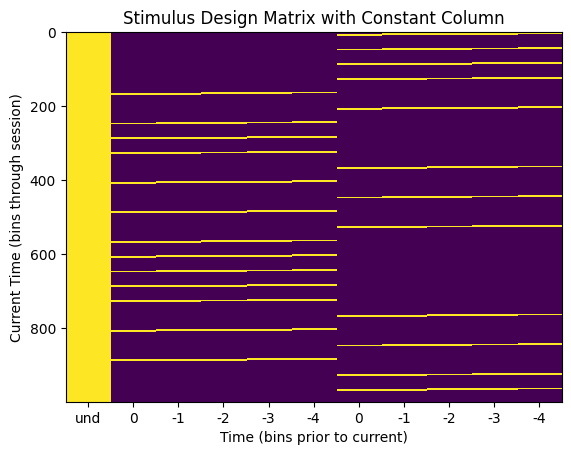

In [22]:
filter_duration = 0.250 # we want a 200 ms window,
filter_length = int(filter_duration / bin_sz) # divide by bin size to yield length of filter
filter_time_bins = np.linspace(-filter_duration, 0, filter_length+1, endpoint=True)

white_design_mat = build_design_mat(white_flashes, d=filter_length)
black_design_mat = build_design_mat(black_flashes, d=filter_length, include_const=False)
comb_design_mat = np.concatenate((white_design_mat, black_design_mat), axis=1)

print(white_design_mat.shape)
print(black_design_mat.shape)
print(comb_design_mat.shape)

# plt.imshow(comb_design_mat[:1000], extent=[-comb_design_mat.shape[1], 0, 1000, 0], aspect="auto", interpolation="none")
plt.imshow(comb_design_mat[:1000], aspect="auto", interpolation="none")
xaxis_step = 1
xpositions = range(0,comb_design_mat.shape[1])[::xaxis_step]
time_offset_axis = range(0, -comb_design_mat.shape[1]//2+1, -1)
xticks = ( ["und"] + list(time_offset_axis) + list(time_offset_axis))[::xaxis_step]

print(xpositions)
print(xticks)
plt.xticks(xpositions, xticks)
plt.xlabel("Time (bins prior to current)")
plt.ylabel("Current Time (bins through session)")
plt.title("Stimulus Design Matrix with Constant Column")


In [23]:
training_outputs = []
for i, spike_times in enumerate(units_spike_times):
    # bin spikes where bins line up with the interpolated flashes timestamps
    these_spikes_binned, _ = np.histogram(spike_times, bins=len(time_axis), range=(start_time,end_time))
    # try:
    res = fit_lnp(comb_design_mat, these_spikes_binned, lam=2**5)
    midpoint = len(res)//2 + 1 # assumes the design mat has odd length
    const = res[0]
    white_filt = res[1:midpoint]
    black_filt = res[midpoint:]
    training_outputs.append((these_spikes_binned, const, white_filt, black_filt))
    # except:
    #     training_outputs.append((these_spikes_binned, np.nan, [], np.nan, []))

y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969, 11) x0: (11,)
y: (5969,) X: (5969,

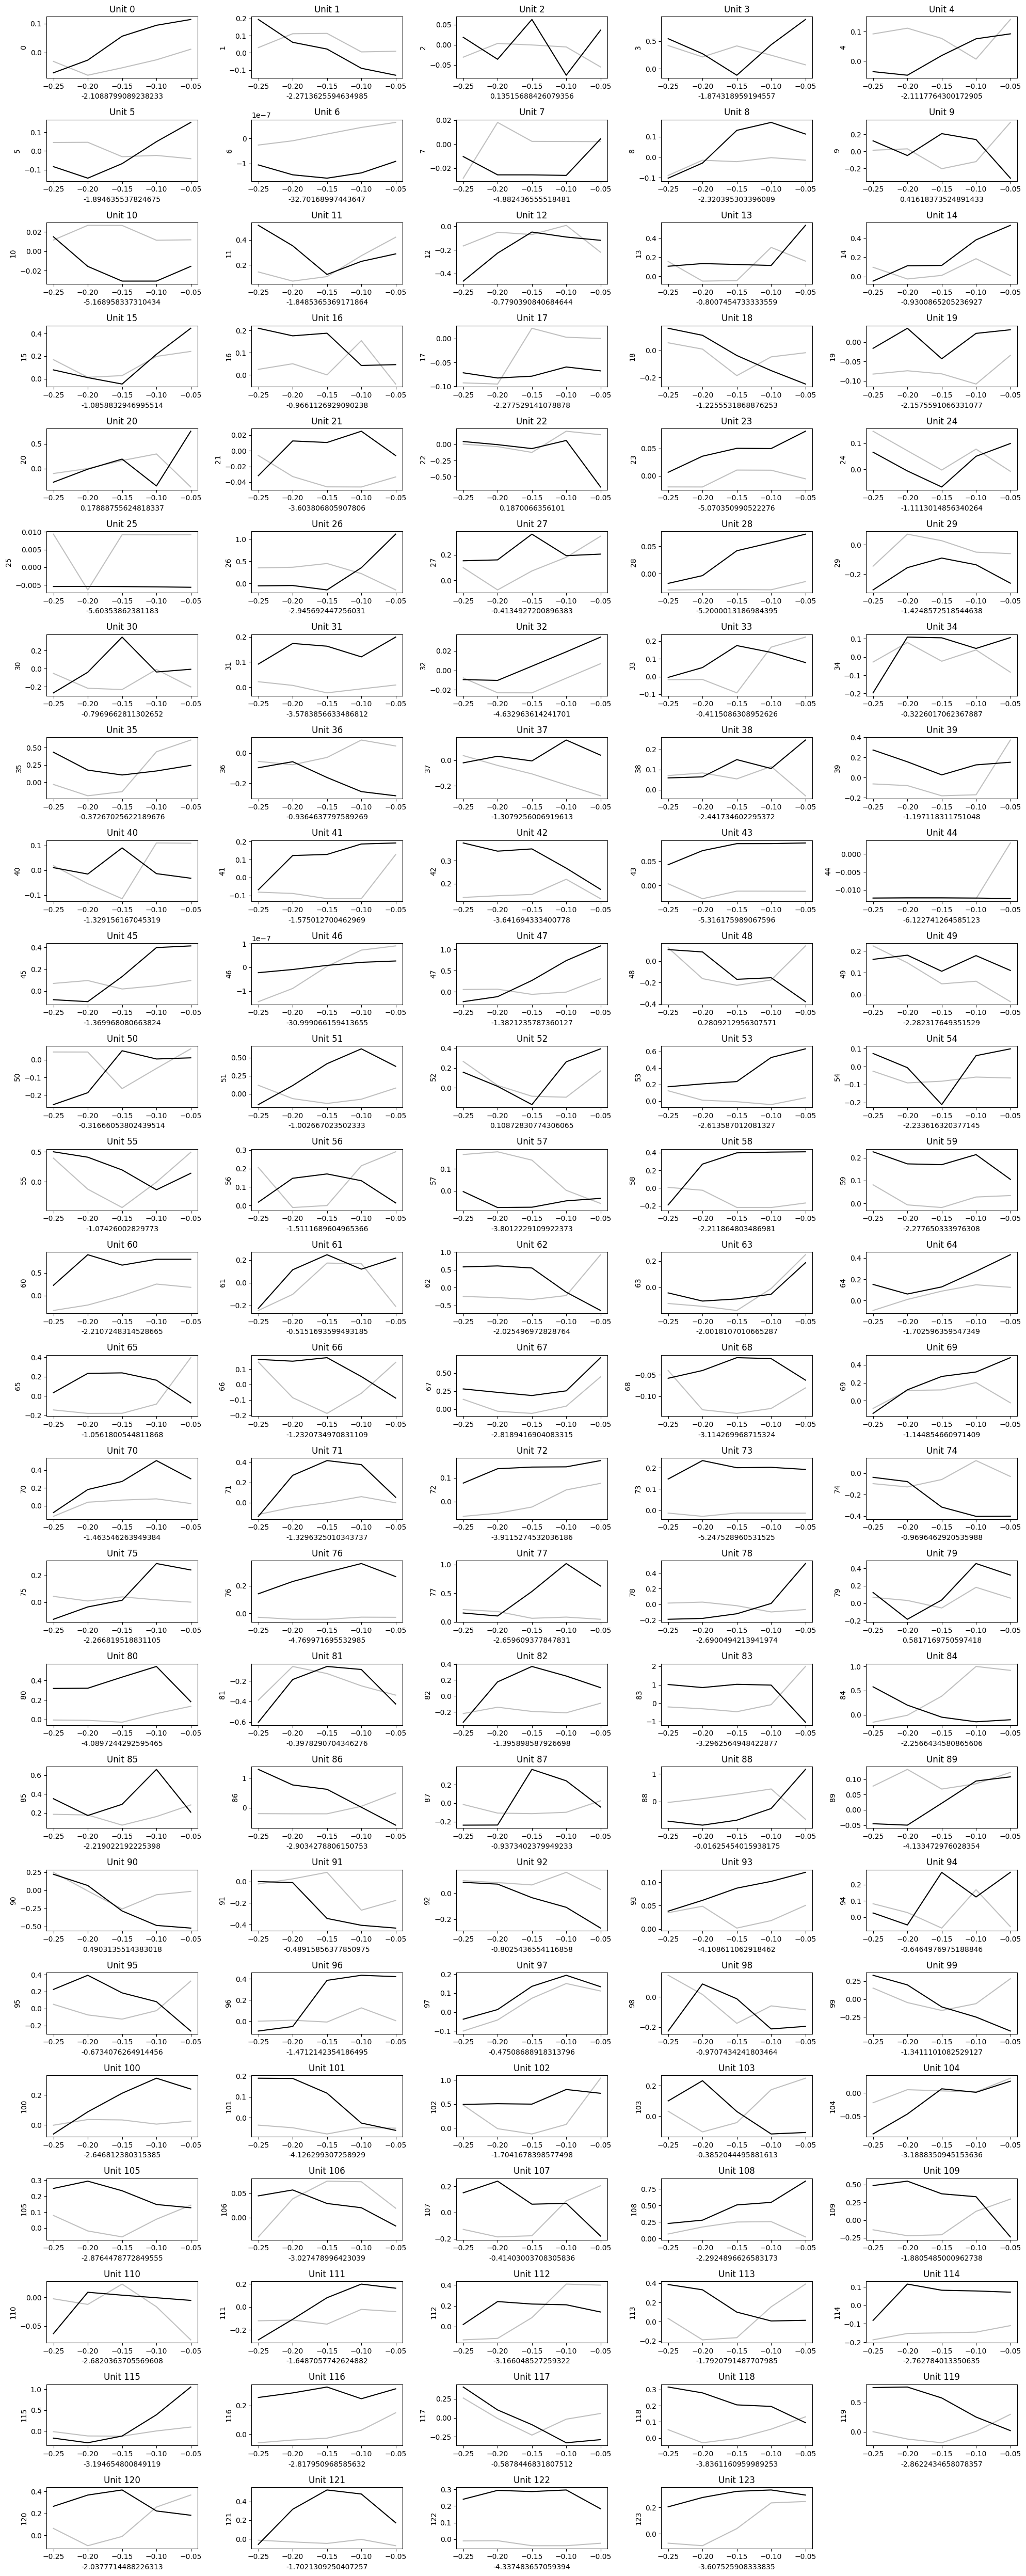

In [24]:
n_cols=5

n_rows = ceil(len(training_outputs)/n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,2*n_rows))
if len(axes.shape) == 1:
    axes = axes.reshape((1, axes.shape[0]))

for i, ax in enumerate(axes.flatten()):
    if i >= len(training_outputs):
        ax.set_visible(False)
        continue
    _, const, white_filt, black_filt = training_outputs[i]
    ax.plot(filter_time_bins[:-1], white_filt, color="silver")
    ax.plot(filter_time_bins[:-1], black_filt, color="black")
    ax.set_ylabel(i)
    ax.set_xlabel(const)
    ax.set_title(f"Unit {i}")

fig.tight_layout()
plt.show()

### Predict Activity
Finally, these trained filters can be applied to the stimulus to generate predicted spiking probability and predicted spike counts. In a real use case, one could provide some hypothetical stimulus values to predict how the units of interest may respond. Note that since the Poisson generation is non-deterministic, the predicted spikes will differ with each run. To evaluate the GLM's performance, the $R^2$ values are calculated between the observed spikes and the predicted spike probability. Note that in the $R^2$ distributions below, performance is higher for predicting black flashes.  

In [25]:
prediction_outputs = []
for spikes_binned, constant, white_filter, black_filter in training_outputs:
    print(white_filter.shape)
    white_predicted_rate = predict(white_design_mat[:,1:], white_filter, constant)
    white_spikes_predicted = predict_spikes(white_design_mat[:,1:], white_filter, constant)
    white_r2 = r2_score(spikes_binned, white_predicted_rate)

    black_predicted_rate = predict(black_design_mat, black_filter, constant)
    black_spikes_predicted = predict_spikes(black_design_mat, black_filter, constant)
    black_r2 = r2_score(spikes_binned, black_predicted_rate)

    print("===")
    print("white observed mean rate:", np.sum(spikes_binned) / len(spikes_binned))
    print("white predicted mean rate:", np.sum(white_spikes_predicted) / len(white_spikes_predicted))
    print("white loss:",white_r2)
    print("black observed mean rate:", np.sum(spikes_binned) / len(spikes_binned))
    print("black predicted mean rate:", np.sum(black_spikes_predicted) / len(black_spikes_predicted))
    print("black loss:",black_r2)

    prediction_outputs.append([white_predicted_rate, white_spikes_predicted, white_r2, black_predicted_rate, black_spikes_predicted, black_r2])

white_r2s = np.array([output[2] for output in prediction_outputs])
black_r2s = np.array([output[5] for output in prediction_outputs])
print("==================")
print("average white loss:",np.mean(white_r2s))
print("average black loss:",np.mean(black_r2s))

(5,)
===
white observed mean rate: 0.1216284134695929
white predicted mean rate: 0.11626738147093316
white loss: 0.0003848557093315552
black observed mean rate: 0.1216284134695929
black predicted mean rate: 0.12196347796950913
black loss: 0.0011426315366189765
(5,)
===
white observed mean rate: 0.10571284972357178
white predicted mean rate: 0.1018596079745351
white loss: 0.0009655136229619332
black observed mean rate: 0.10571284972357178
black predicted mean rate: 0.1038699949740325
black loss: 0.0017283559296648043
(5,)
===
white observed mean rate: 1.139051767465237
white predicted mean rate: 1.1470933154632266
white loss: 0.0003733266939996982
black observed mean rate: 1.139051767465237
black predicted mean rate: 1.140392025464902
black loss: 0.0003282379855058526
(5,)
===
white observed mean rate: 0.2186295861953426
white predicted mean rate: 0.18311274920422183
white loss: 0.017914792592427897
black observed mean rate: 0.2186295861953426
black predicted mean rate: 0.19467247445133

Text(0, 0.5, '# Units')

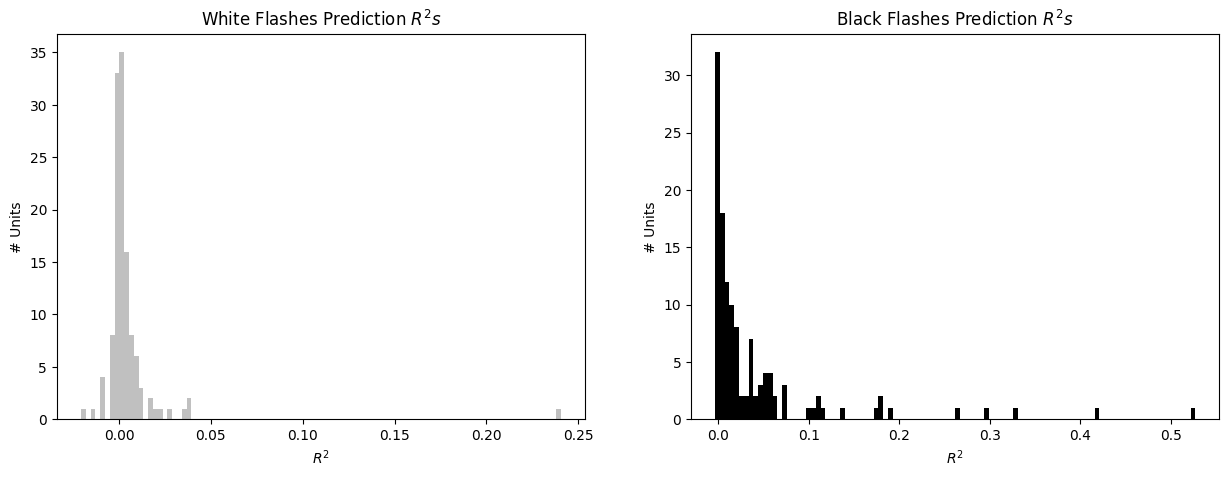

In [26]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

axes[0].hist(white_r2s, bins=100, color="silver")
axes[0].set_title("White Flashes Prediction $R^2s$")
axes[0].set_xlabel("$R^2$")
axes[0].set_ylabel("# Units")

axes[1].hist(black_r2s, bins=100, color="black")
axes[1].set_title("Black Flashes Prediction $R^2s$")
axes[1].set_xlabel("$R^2$")
axes[1].set_ylabel("# Units")

### Showing Predictions
Here, each model is plotted trained filter and prediction outputs. For ease of interpretation and to save space, only the best performing GLMs are displayed. This is done by selecting the prediction outputs with an $R^2$ higher than 0.05. Model fitting is useful if you are expecting neuronal activity to follow a certain behavior. In the case of our Poisson model, we impose a certain response formula and fit the data to it. It can be sometimes useful to compare this fit with a more open-ended selection of cells: for instance, selecting cells simply based on whether the cell fired above a certain threshold. The combination of both approaches can allow to select cells to which fitting a model yield meaningful insights. In some cases, a non-responsive cell could provide model parameters that are hard to interpret. So it is always judicious to combine approaches.

In the first plot below, it can be seen that there is only one White Flashes model with an $R^2$ greater than 0.05, indicating that in these data, units are less reliably responsive to white flashes than black. For each unit, real observed spikes given are shown, along with the trained model's filter. Then the predicted spike rate, which as a reminder is the trained filter convolved over the input flashes. Finally, there is the predicted spikes which are the result of running the predicted spike rate through poisson generation. Because poisson is non-determinstic, these may look different every run.

In [27]:
white_best_fits = white_r2s > 0.05
white_best_training_outputs = np.array(training_outputs, dtype=object)[white_best_fits]
white_best_prediction_outputs = np.array(prediction_outputs, dtype=object)[white_best_fits]

black_best_fits = black_r2s > 0.05
black_best_training_outputs = np.array(training_outputs, dtype=object)[black_best_fits]
black_best_prediction_outputs = np.array(prediction_outputs, dtype=object)[black_best_fits]

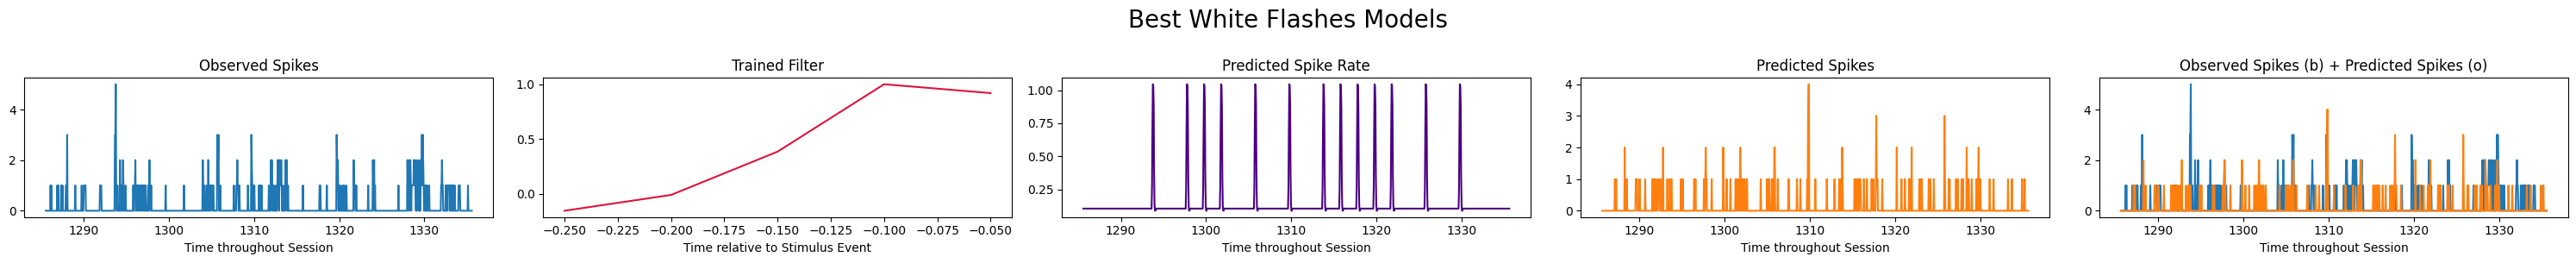

In [28]:
n_cells = len(white_best_training_outputs)
fig, axes = plt.subplots(n_cells, 5, figsize=(30,2*n_cells+1))
if len(axes.shape) == 1:
    axes = np.expand_dims(axes, 0)

for i in range(len(white_best_training_outputs)):
    spikes_binned, constant, filter, _ = white_best_training_outputs[i]
    predicted_rate, spikes_predicted, r2, _, _, _ = white_best_prediction_outputs[i]

    time_range_start = 0
    time_range_end = 1000
    axes[i][0].plot(time_axis[time_range_start:time_range_end], spikes_binned[time_range_start:time_range_end])
    axes[i][1].plot(filter_time_bins[:-1], filter, color="crimson")
    axes[i][2].plot(time_axis[time_range_start:time_range_end], predicted_rate[time_range_start:time_range_end], color="indigo")
    axes[i][3].plot(time_axis[time_range_start:time_range_end], spikes_predicted[time_range_start:time_range_end], color="tab:orange")
    axes[i][4].plot(time_axis[time_range_start:time_range_end], spikes_binned[time_range_start:time_range_end])
    axes[i][4].plot(time_axis[time_range_start:time_range_end], spikes_predicted[time_range_start:time_range_end], color="tab:orange")

axes[0][0].set_title("Observed Spikes")
axes[0][1].set_title("Trained Filter")
axes[0][2].set_title("Predicted Spike Rate")
axes[0][3].set_title("Predicted Spikes")
axes[0][4].set_title("Observed Spikes (b) + Predicted Spikes (o)")
for ax_x, ax_y in ((0,0), (0,2), (0,3), (0,4), (-1,0), (-1,2), (-1,3), (-1,4)):
    axes[ax_x][ax_y].set_xlabel("Time throughout Session")
for ax_x, ax_y in ((0,1), (-1,1)):
    axes[ax_x][ax_y].set_xlabel("Time relative to Stimulus Event")

fig.suptitle("Best White Flashes Models", y=1, size=20)
fig.tight_layout()
plt.show()

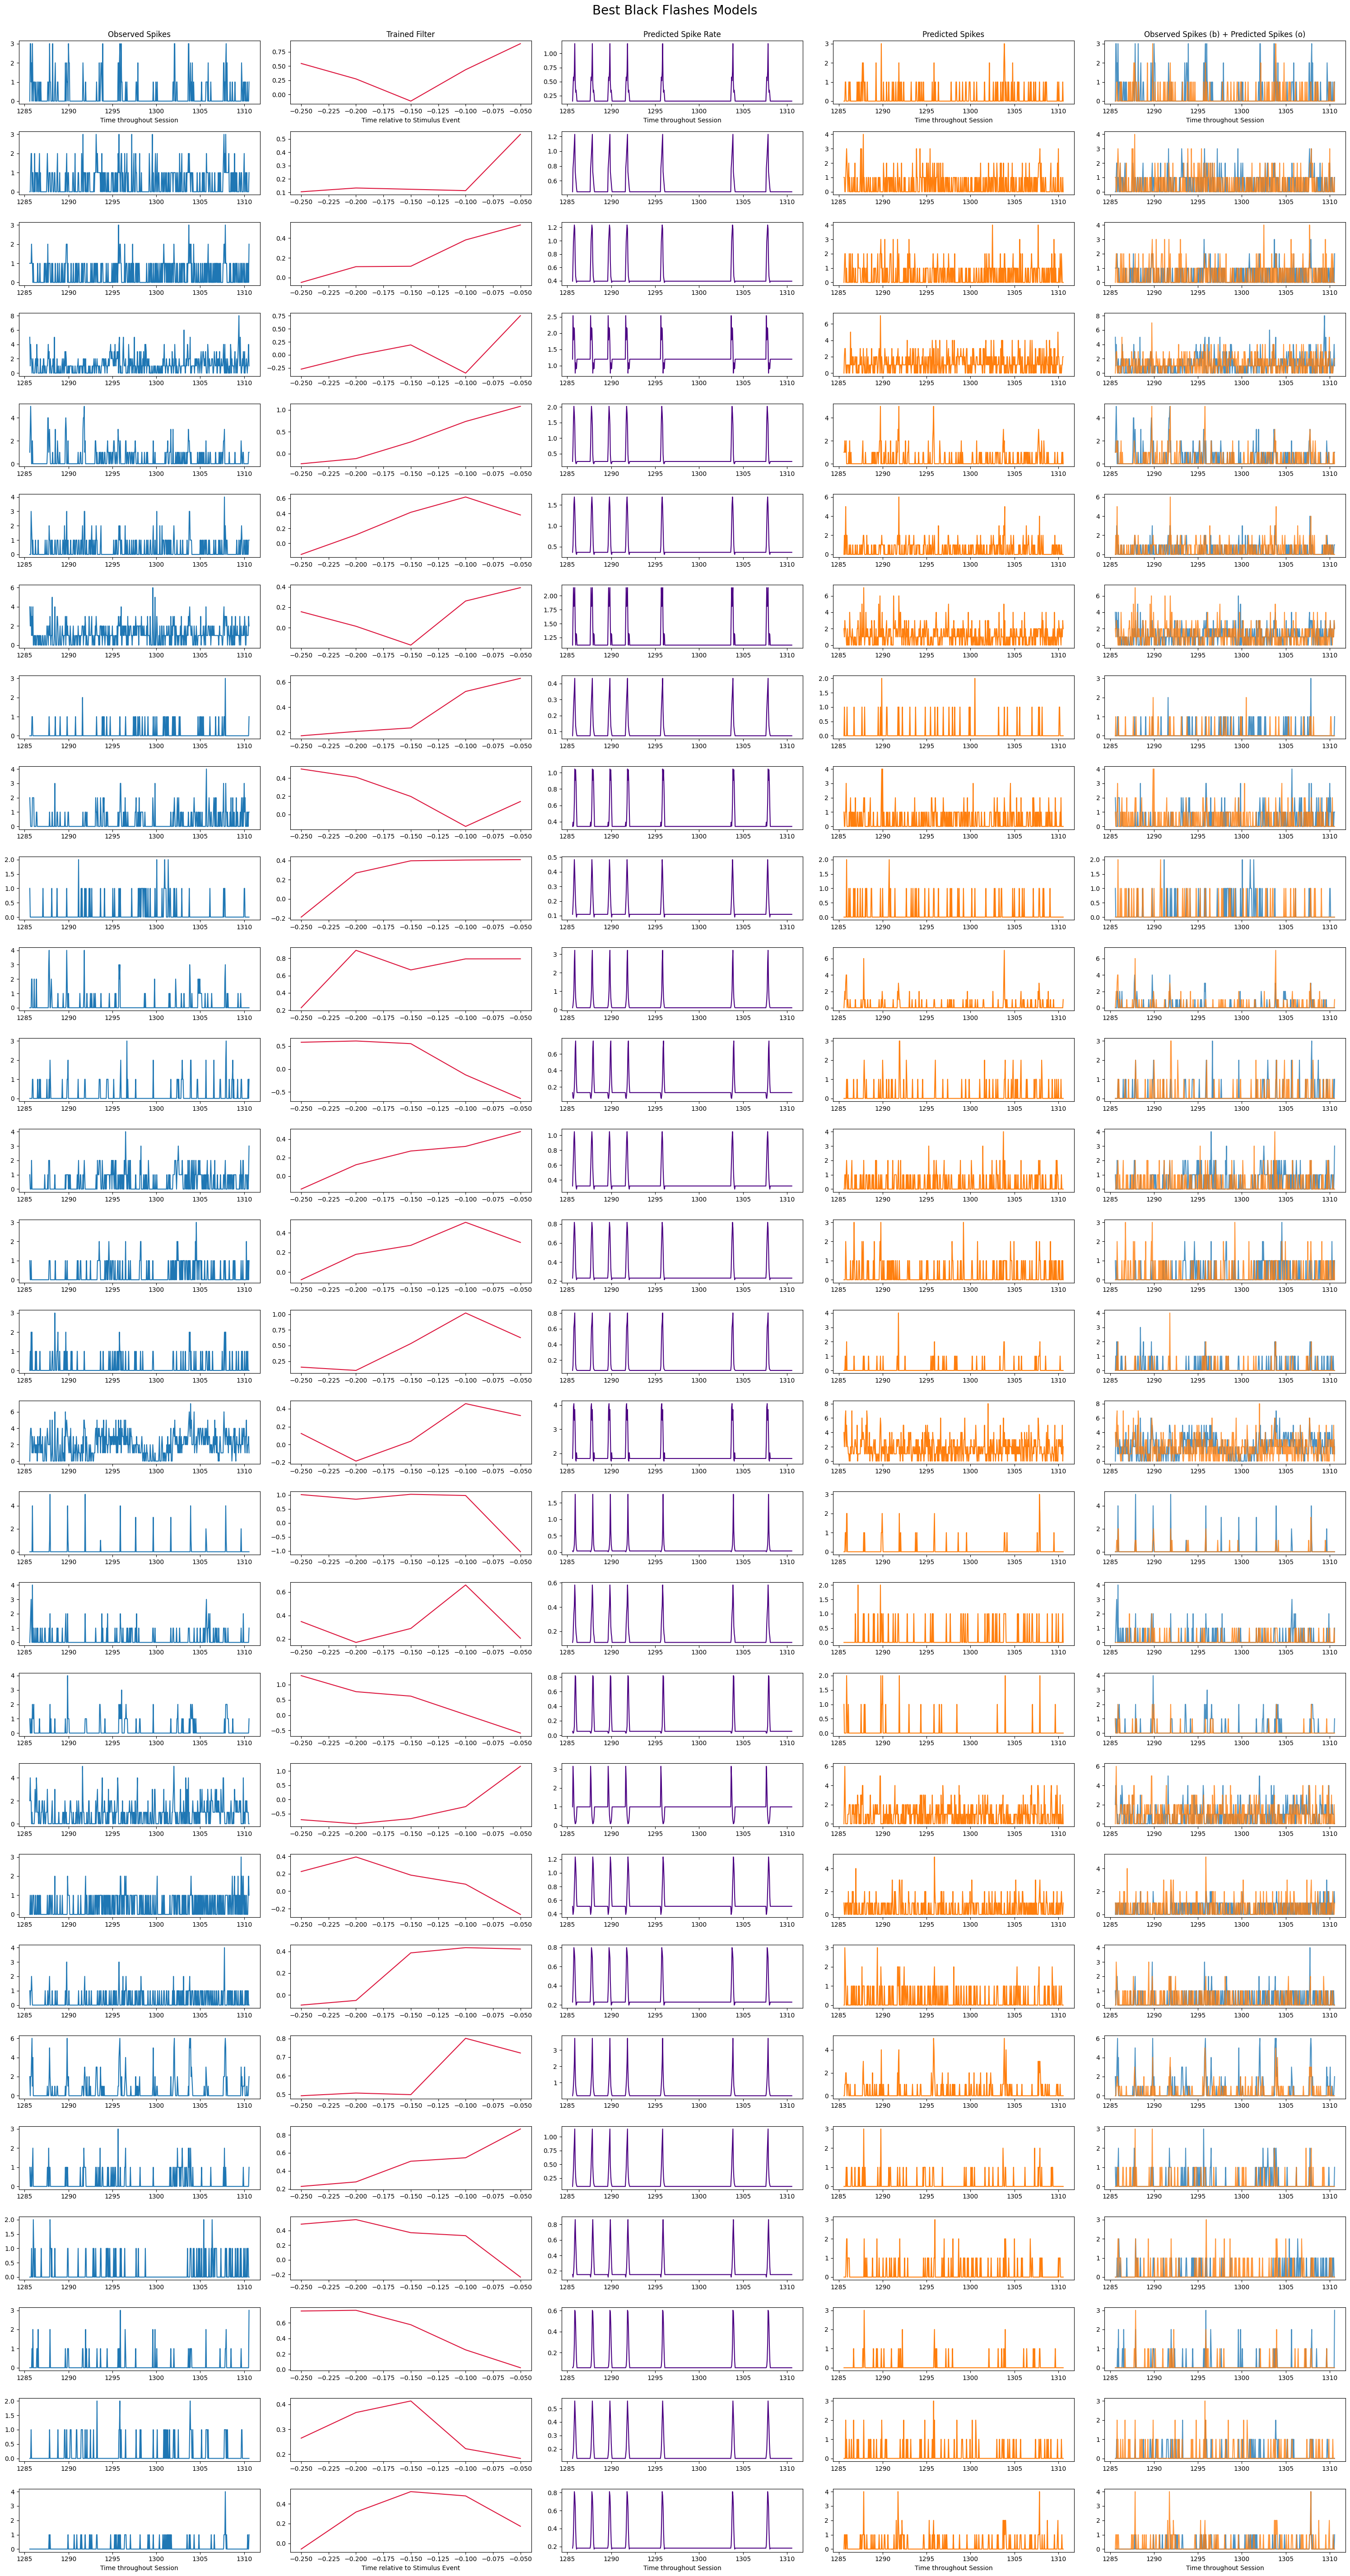

In [29]:
n_cells = len(black_best_training_outputs)
fig, axes = plt.subplots(n_cells, 5, figsize=(30,2*n_cells+1))
if len(axes.shape) == 1:
    axes = np.expand_dims(axes, 0)

for i in range(len(black_best_training_outputs)):
    spikes_binned, constant, _, filter = black_best_training_outputs[i]
    _, _, _, predicted_rate, spikes_predicted, r2 = black_best_prediction_outputs[i]

    time_range_start = 0
    time_range_end = 500
    axes[i][0].plot(time_axis[time_range_start:time_range_end], spikes_binned[time_range_start:time_range_end])
    axes[i][1].plot(filter_time_bins[:-1], filter, color="crimson")
    axes[i][2].plot(time_axis[time_range_start:time_range_end], predicted_rate[time_range_start:time_range_end], color="indigo")
    axes[i][3].plot(time_axis[time_range_start:time_range_end], spikes_predicted[time_range_start:time_range_end], color="tab:orange")
    axes[i][4].plot(time_axis[time_range_start:time_range_end], spikes_binned[time_range_start:time_range_end], alpha=0.8)
    axes[i][4].plot(time_axis[time_range_start:time_range_end], spikes_predicted[time_range_start:time_range_end], color="tab:orange", alpha=0.8)

axes[0][0].set_title("Observed Spikes")
axes[0][1].set_title("Trained Filter")
axes[0][2].set_title("Predicted Spike Rate")
axes[0][3].set_title("Predicted Spikes")
axes[0][4].set_title("Observed Spikes (b) + Predicted Spikes (o)")
for ax_x, ax_y in ((0,0), (0,2), (0,3), (0,4), (-1,0), (-1,2), (-1,3), (-1,4)):
    axes[ax_x][ax_y].set_xlabel("Time throughout Session")
for ax_x, ax_y in ((0,1), (-1,1)):
    axes[ax_x][ax_y].set_xlabel("Time relative to Stimulus Event")

fig.suptitle("Best Black Flashes Models", y=1, size=20)
fig.tight_layout()
plt.show()

### Comparing to Z-Scores

In [30]:
# start and end times (relative to the stimulus at 0 seconds) that we want to examine and align spikes to
window_start_time = -(filter_length * bin_sz)
window_end_time = (filter_length * bin_sz)

In [31]:
def get_spike_matrix(stim_times, units_spike_times, bin_edges):
    time_resolution = np.mean(np.diff(bin_edges))
    # 3D spike matrix to be populated with spike counts
    spike_matrix = np.zeros((len(units_spike_times), len(stim_times), len(bin_edges)-1))

    # populate 3D spike matrix for each unit for each stimulus trial by counting spikes into bins
    for unit_idx in range(len(units_spike_times)):
        spike_times = units_spike_times[unit_idx]

        for stim_idx, stim_time in enumerate(stim_times):
            # get spike times that fall within the bin's time range relative to the stim time        
            first_bin_time = stim_time + bin_edges[0]
            last_bin_time = stim_time + bin_edges[-1]
            first_spike_in_range, last_spike_in_range = np.searchsorted(spike_times, [first_bin_time, last_bin_time])
            spike_times_in_range = spike_times[first_spike_in_range:last_spike_in_range]

            # convert spike times into relative time bin indices
            bin_indices = ((spike_times_in_range - (first_bin_time)) / time_resolution).astype(int)
            
            # mark that there is a spike at these bin times for this unit on this stim trial
            for bin_idx in bin_indices:
                spike_matrix[unit_idx, stim_idx, bin_idx] += 1

    return spike_matrix

In [32]:
white_flash_times = time_axis[[i for i in range(1,len(white_flashes)) if white_flashes[i] == 1 and white_flashes[i-1] == 0]]
black_flash_times = time_axis[[i for i in range(1,len(black_flashes)) if black_flashes[i] == 1 and black_flashes[i-1] == 0]]

# time bins used
n_bins = int((window_end_time - window_start_time) / bin_sz)
bin_edges = np.linspace(window_start_time, window_end_time, n_bins+1, endpoint=True)
# bin_edges = np.concatenate((filter_time_bins, -filter_time_bins[:-1][::-1]))

# calculate baseline and stimulus interval indices for use later
stimulus_onset_idx = int(-bin_edges[0] / bin_sz)

white_flash_responses = get_spike_matrix(white_flash_times, units_spike_times, bin_edges)
black_flash_responses = get_spike_matrix(black_flash_times, units_spike_times, bin_edges)

# has shape neuro * trials * time
print(white_flash_responses.shape)
print(black_flash_responses.shape)

(124, 75, 10)
(124, 75, 10)


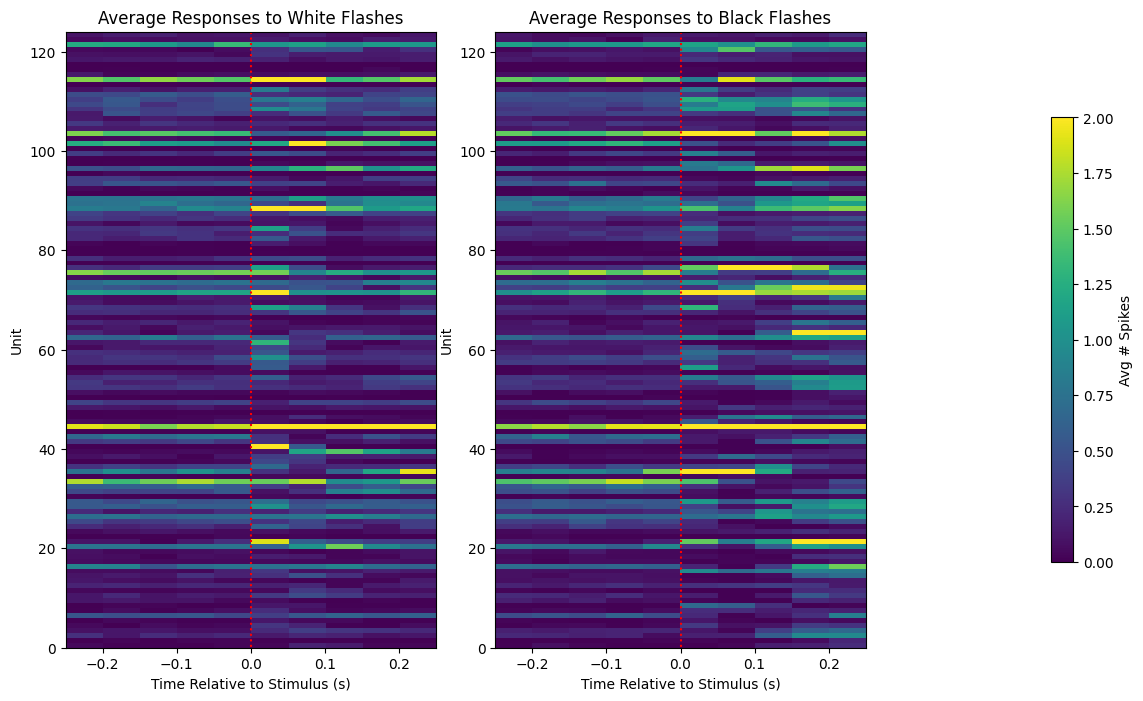

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(13,8), gridspec_kw={"width_ratios":[1,1,0.4]})
vmax = 2
axes[0].imshow(np.mean(white_flash_responses, axis=1), vmax=vmax, extent=[bin_edges[0], bin_edges[-1], 0, len(units_spike_times)], aspect="auto")
# axes[0].imshow(np.mean(white_flash_responses, axis=1), vmax=vmax, aspect="auto")
axes[0].vlines(0, white_flash_responses.shape[0], 0, colors="r", ls=":")
axes[0].set_title("Average Responses to White Flashes")
axes[0].set_xlabel("Time Relative to Stimulus (s)")
axes[0].set_ylabel("Unit")

img = axes[1].imshow(np.mean(black_flash_responses, axis=1), vmax=vmax, extent=[bin_edges[0], bin_edges[-1], 0, len(units_spike_times)], aspect="auto")
# img = axes[1].imshow(np.mean(black_flash_responses, axis=1), vmax=vmax, aspect="auto")
axes[1].vlines(0, black_flash_responses.shape[0], 0, colors="r", ls=":")
axes[1].set_title("Average Responses to Black Flashes")
axes[1].set_xlabel("Time Relative to Stimulus (s)")
axes[1].set_ylabel("Unit")

cbar = fig.colorbar(img, ax=axes[2])
axes[2].set_visible(False)
cbar.set_label("Avg # Spikes")

In [34]:
def get_zscore_mat(spike_matrix, stimulus_onset_idx):
    """
    Inputs:
    The 3D spike matrix with dimensions, Unit * Trial * Time, where values are the # of spikes in each bin
    The index of the time dimension when we expect the stimulus to be shown

    Outputs:
    A 2D matrix with dimensions Unit * Time, where values are the trial-averaged z-scores between the pre-stimulus (baseline) and post-stimulus (evoked) time periods
    Z-score for each bin is defined as the (bin value - baseline mean) / baseline standard deviation
    """

    baseline_rates = np.mean(spike_matrix[:,:,:stimulus_onset_idx], axis=2)
    baseline_stds = np.std(spike_matrix[:,:,:stimulus_onset_idx], axis=2)

    mean_baseline_rate = np.expand_dims(np.mean(baseline_rates, axis=1), 1)
    mean_baseline_stds = np.expand_dims(np.mean(baseline_stds, axis=1), 1) + 0.1 # to prevent division by 0

    zscores = (np.mean(spike_matrix, axis=1) - mean_baseline_rate) / mean_baseline_stds
    return zscores

white_flash_zscores = get_zscore_mat(white_flash_responses, stimulus_onset_idx)
black_flash_zscores = get_zscore_mat(black_flash_responses, stimulus_onset_idx)

print(white_flash_zscores.shape)
print(black_flash_zscores.shape)

(124, 10)
(124, 10)


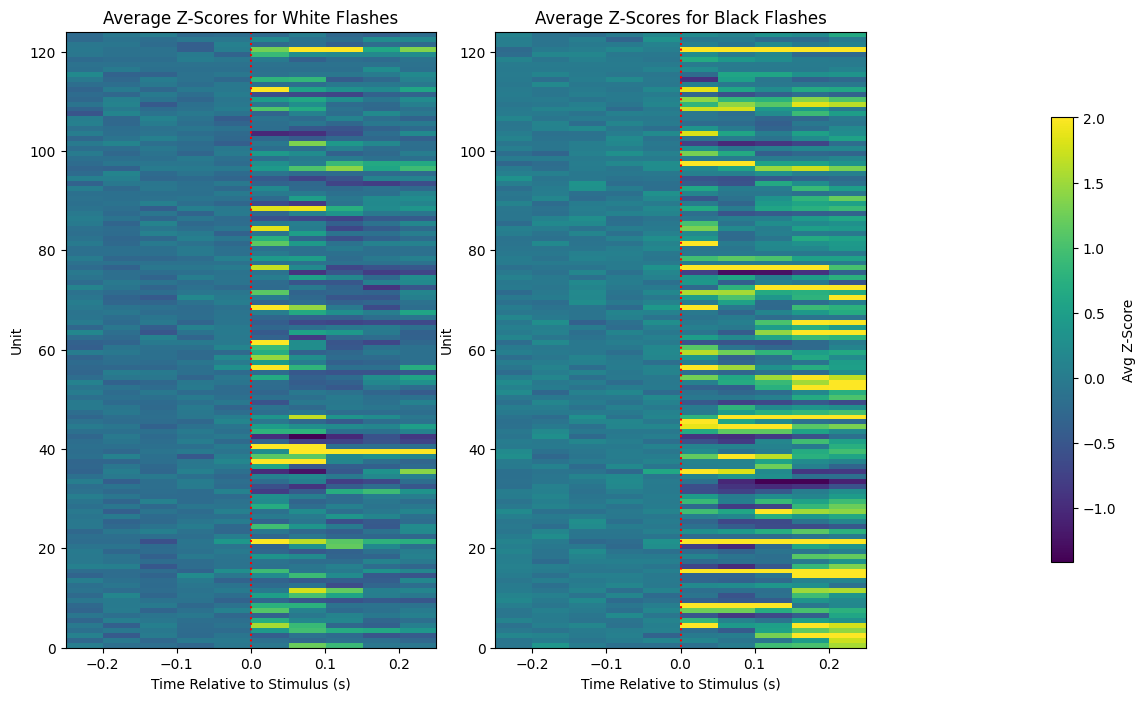

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(13,8), gridspec_kw={"width_ratios":[1,1,0.4]})
vmax=2
axes[0].imshow(white_flash_zscores, vmax=vmax, extent=[bin_edges[0], bin_edges[-1], 0, len(units_spike_times)], aspect="auto")
axes[0].vlines(0, white_flash_zscores.shape[0], 0, colors="r", ls=":")
axes[0].set_title("Average Z-Scores for White Flashes")
axes[0].set_xlabel("Time Relative to Stimulus (s)")
axes[0].set_ylabel("Unit")

img = axes[1].imshow(black_flash_zscores, vmax=vmax, extent=[bin_edges[0], bin_edges[-1], 0, len(units_spike_times)], aspect="auto")
axes[1].vlines(0, black_flash_zscores.shape[0], 0, colors="r", ls=":")
axes[1].set_title("Average Z-Scores for Black Flashes")
axes[1].set_xlabel("Time Relative to Stimulus (s)")
axes[1].set_ylabel("Unit")

cbar = fig.colorbar(img, ax=axes[2])
axes[2].set_visible(False)
cbar.set_label("Avg Z-Score")

### Selecting Most Responsive Units
Of the units whose z-scores are shown above, the most responsive ones are selected and plotted if their maximum z-score is greater than 2. It can be seen that there are many more units with high z-scores for black flashes. This is more evidence that units are more responsive to the black flash stimulus rather than white flashes.

In [36]:
# pick top 10 most responsive units
white_max_zscores = np.max(white_flash_zscores[:,stimulus_onset_idx:], axis=1)
top_white_units = np.nonzero(white_max_zscores > 2)[0]
top_white_zscores = white_flash_zscores[top_white_units]

black_max_zscores = np.max(black_flash_zscores[:,stimulus_onset_idx:], axis=1)
top_black_units = np.nonzero(black_max_zscores > 2)[0]
top_black_zscores = black_flash_zscores[top_black_units]

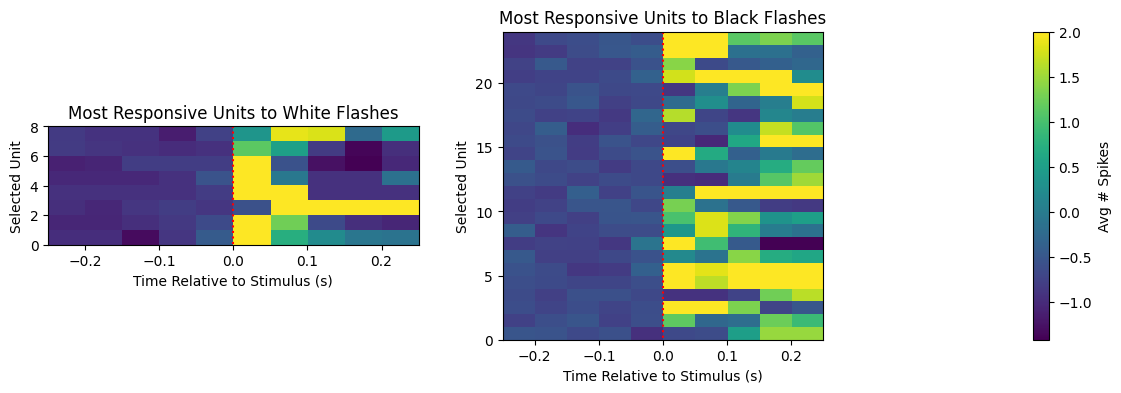

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(13,4), gridspec_kw={"width_ratios":[1,1,0.4]})

axes[0].imshow(top_white_zscores, vmax=3, extent=[bin_edges[0], bin_edges[-1], 0, len(top_white_units)], aspect=0.02)
axes[0].vlines(0, top_white_zscores.shape[0], 0, colors="r", ls=":")
axes[0].set_title("Most Responsive Units to White Flashes")
axes[0].set_xlabel("Time Relative to Stimulus (s)")
axes[0].set_ylabel("Selected Unit")
axes[1].imshow(top_black_zscores, vmax=3, extent=[bin_edges[0], bin_edges[-1], 0, len(top_black_units)], aspect=0.02)
axes[1].vlines(0, top_black_zscores.shape[0], 0, colors="r", ls=":")
axes[1].set_title("Most Responsive Units to Black Flashes")
axes[1].set_xlabel("Time Relative to Stimulus (s)")
axes[1].set_ylabel("Selected Unit")

cbar = fig.colorbar(img, ax=axes[2])
axes[2].set_visible(False)
cbar.set_label("Avg # Spikes")

### Comparing Z-Scores with GLM Filters
As we've seen, both the trained GLM filter and the response Z-scores can give an interpretation of unit responsiveness. Below, the most responsive units from estimations of the strongest Z-Scores and the best fitting GLMs are plotted and compared.

It can be noticed that the filters may be negative. Recall that when the spiking probability is predicted by the GLM, the trained filter is convolved over the input stimulus, and then added to by a trained constant that represents the baseline firing rate. This means a negative filter indicates that a recent stimulus will decrease the predicted firing rate and a positive filter will increase predicted firing rate, relative to the trained constant's baseline firing rate.

Another thing that might be noticed is that the filters sometimes appear to be a mirror image the stimulus evoked spiking over time. This is expected. Since the filters are convolved over the stimulus with each time point being negative, the resulting shape would resemble something like the forward response shown in the spiking plots.


It is important to note that because we are selected units that are apparently the most responsive, these filters and spike counts will be the clearest and most meaningful examples. Many of the other filters may just represent noise or be much harder to interpret. 


In [38]:
print("Units most responsive to white flashes:", np.sort(top_white_units))
print("Units most responsive to black flashes:", np.sort(top_black_units))
print("Units that produced best fitting GLMs for white flashes:", np.nonzero(white_best_fits)[0])
print("Units that produced best fitting GLMs for black flashes:", np.nonzero(black_best_fits)[0])

Units most responsive to white flashes: [  3  55  62  67  83  84  86 102]
Units most responsive to black flashes: [  3  26  42  47  51  53  55  58  60  67  70  71  77  78  79  85  88  96
 102 108 109 115 119 121]
Units that produced best fitting GLMs for white flashes: [84]
Units that produced best fitting GLMs for black flashes: [  3  13  14  20  47  51  52  53  55  58  60  62  69  70  77  79  83  85
  86  88  95  96 102 108 109 119 120 121]


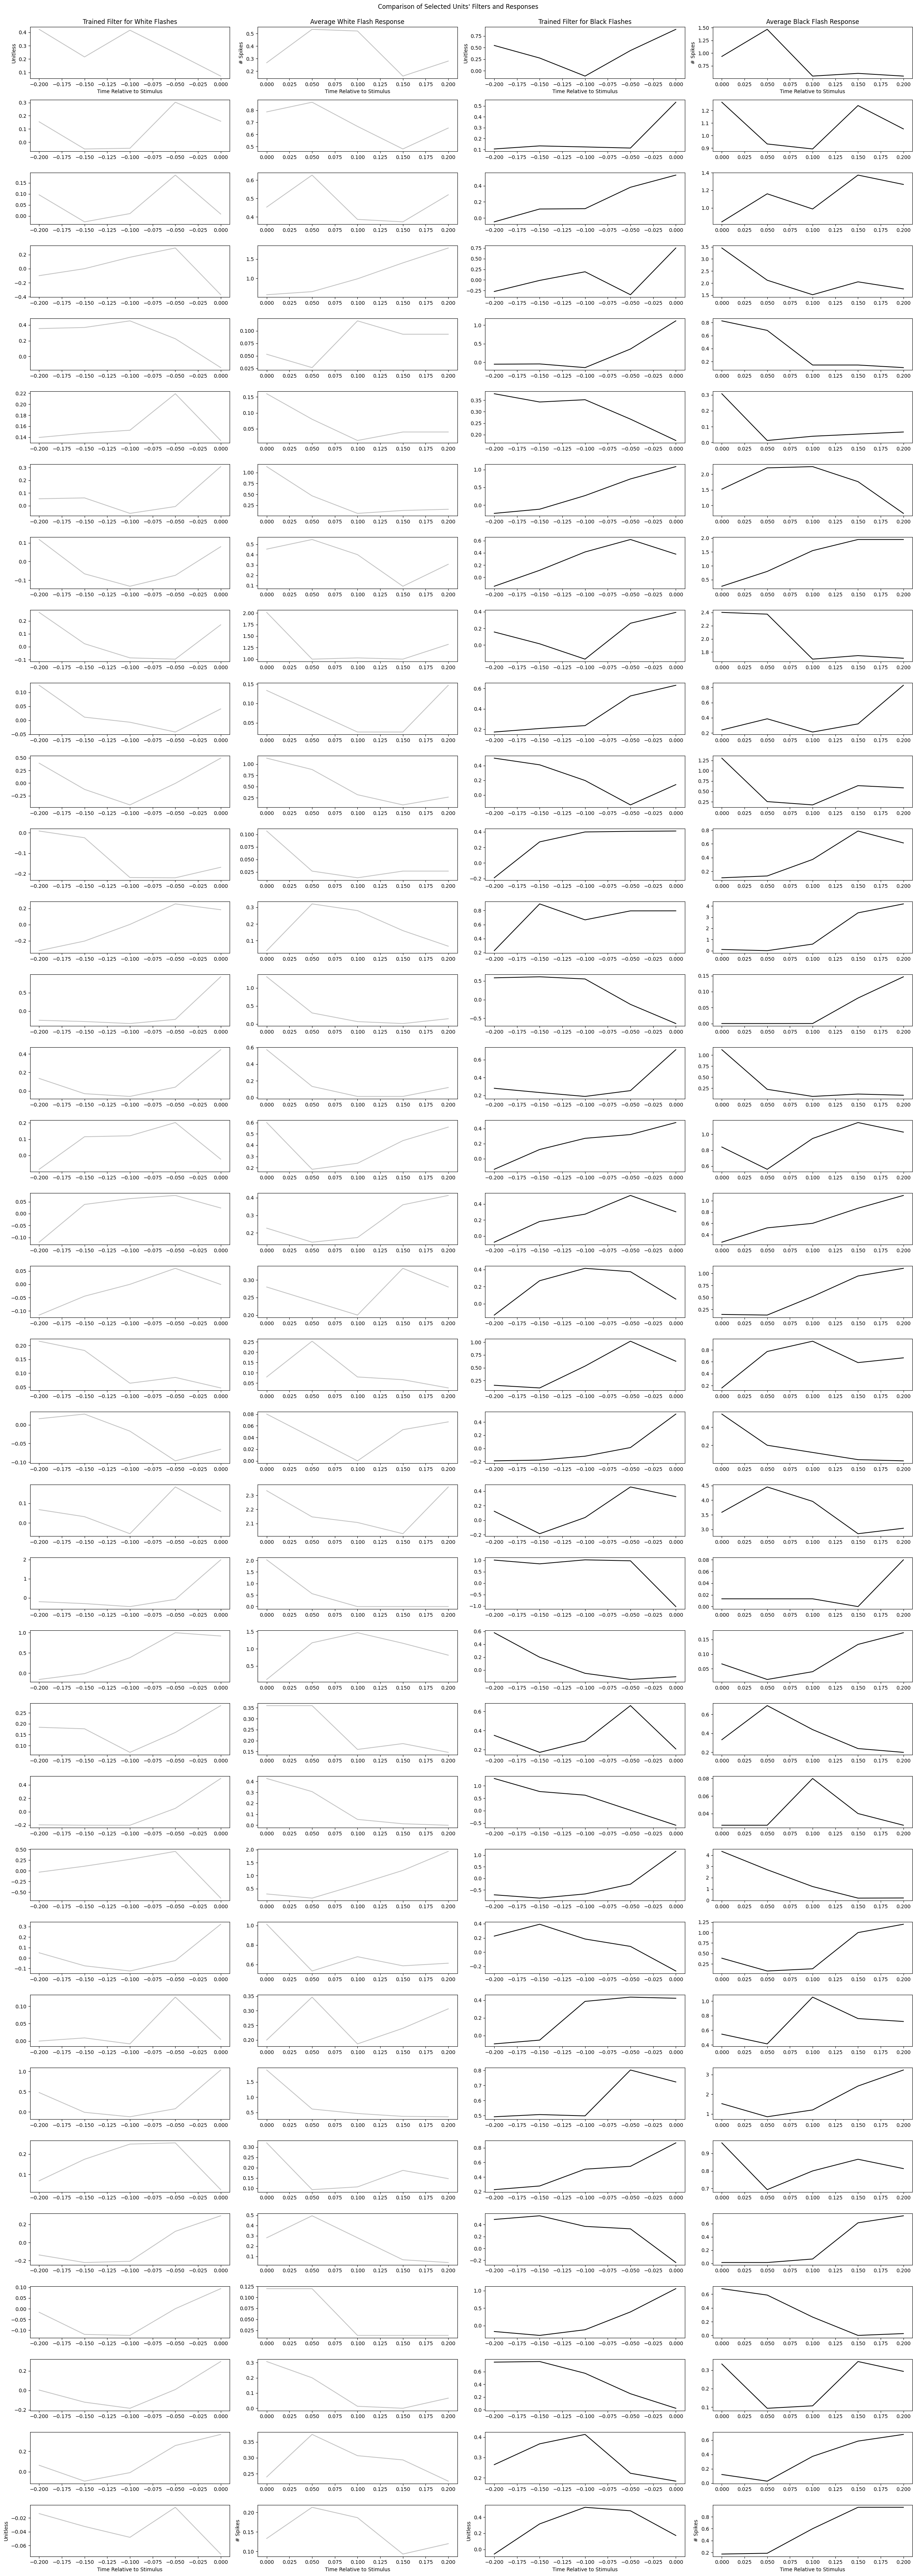

In [39]:
units_of_interest = reduce(np.union1d, (top_white_units, top_black_units, np.nonzero(white_best_fits)[0], np.nonzero(black_best_fits)[0]))

fig, axes = plt.subplots(len(units_of_interest), 4, figsize=(25, 2*len(units_of_interest)))
for i, unit_id in enumerate(units_of_interest):
    spikes_binned, constant, white_filter, black_filter = training_outputs[unit_id]
    mean_white_response = np.mean(white_flash_responses[unit_id], axis=0)
    mean_black_response = np.mean(black_flash_responses[unit_id], axis=0)

    axes[i][0].plot(filter_time_bins[1:], white_filter, color="silver")
    axes[i][1].plot(bin_edges[stimulus_onset_idx:-1], mean_white_response[stimulus_onset_idx:], color="silver")
    axes[i][2].plot(filter_time_bins[1:], black_filter, color="black")
    axes[i][3].plot(bin_edges[stimulus_onset_idx:-1], mean_black_response[stimulus_onset_idx:], color="black")

# give axis labels to first and last plots
for ax_x, ax_y in ((0,0), (0,1), (0,2), (0,3), (-1,0), (-1,1), (-1,2), (-1,3)):
    axes[ax_x][ax_y].set_xlabel("Time Relative to Stimulus")

for ax_x, ax_y in ((0,0), (0,2), (-1,0), (-1,2)):
    axes[ax_x][ax_y].set_ylabel("Unitless")

for ax_x, ax_y in ((0,1), (0,3), (-1,1), (-1,3)):
    axes[ax_x][ax_y].set_ylabel("# Spikes")

axes[0][0].set_title("Trained Filter for White Flashes")
axes[0][1].set_title("Average White Flash Response")
axes[0][2].set_title("Trained Filter for Black Flashes")
axes[0][3].set_title("Average Black Flash Response")
fig.suptitle("Comparison of Selected Units' Filters and Responses", y=0.999)
fig.tight_layout()